<a href="https://colab.research.google.com/github/afnankhan123456/ML-project/blob/main/cat_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

#DATA CLEANING

In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras.callbacks import EarlyStopping

In [5]:
#Generaters yani big data ko small part me devided krna
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)

)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)

)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [6]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 90.0 MB/s eta 0:00:00


In [14]:
#DATA CLEANING PART
import os
import cv2
from PIL import Image
import imagehash

def clean_data(dataset_path, dataset_name, min_size=(50, 50), blur_threshold=100):
    # Lists to store various types of issues
    corrupt_images = []
    non_image_files = []
    empty_folders = []
    duplicate_hashes = set()
    duplicate_images = []
    unusual_size_images = []
    blurry_images = []
    class_counts = {}

    for root, dirs, files in os.walk(dataset_path):
        if not files and not dirs:
            empty_folders.append(root)

        for file in files:
            file_path = os.path.join(root, file)

            # Non-image file check
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                non_image_files.append(file_path)
                continue

            # Corrupt image check
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                corrupt_images.append(file_path)
                continue

            # Unusual size check
            try:
                with Image.open(file_path) as img:
                    if img.size[0] < min_size[0] or img.size[1] < min_size[1]:
                        unusual_size_images.append(file_path)
            except Exception:
                continue

            # Duplicate image detection
            try:
                with Image.open(file_path) as img:
                    hash_val = imagehash.average_hash(img)
                    if hash_val in duplicate_hashes:
                        duplicate_images.append(file_path)
                    else:
                        duplicate_hashes.add(hash_val)
            except Exception:
                continue

            # Blurry image check
            try:
                img = cv2.imread(file_path)
                if img is None:
                    continue
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                variance = cv2.Laplacian(gray, cv2.CV_64F).var()
                if variance < blur_threshold:
                    blurry_images.append(file_path)
            except Exception:
                continue

    # Class distribution
    for root, dirs, _ in os.walk(dataset_path):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            if os.path.isdir(folder_path):
                image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                class_counts[folder] = len(image_files)

    # Print summary
    print(f"\n{dataset_name} Dataset Clean Report")
    print("=" * (len(dataset_name) + 23))
    print(f"Corrupt Images: {len(corrupt_images)}")
    print(f"Non-Image Files: {len(non_image_files)}")
    print(f"Empty Folders: {len(empty_folders)}")
    print(f"Duplicate Images: {len(duplicate_images)}")
    print(f"Unusual Size Images: {len(unusual_size_images)}")
    print(f"Blurry Images Found: {len(blurry_images)}")
    print(f"Class Distribution: {class_counts}")
    print("Wrong Class Images (manual check): Not handled here")

    return {
        "corrupt_images": corrupt_images,
        "non_image_files": non_image_files,
        "empty_folders": empty_folders,
        "duplicate_images": duplicate_images,
        "unusual_size_images": unusual_size_images,
        "blurry_images": blurry_images,
        "class_distribution": class_counts
    }

# Paths
dataset_path_train = '/content/train'
dataset_path_test = '/content/test'

# Clean the training dataset
clean_report_train = clean_data(dataset_path_train, "Train")
# Clean the testing dataset
clean_report_test = clean_data(dataset_path_test, "Test")



Train Dataset Clean Report
Corrupt Images: 0
Non-Image Files: 0
Empty Folders: 0
Duplicate Images: 18
Unusual Size Images: 0
Blurry Images Found: 0
Class Distribution: {'cats': 8468, 'dogs': 9088}
Wrong Class Images (manual check): Not handled here

Test Dataset Clean Report
Corrupt Images: 0
Non-Image Files: 0
Empty Folders: 0
Duplicate Images: 0
Unusual Size Images: 0
Blurry Images Found: 0
Class Distribution: {'cats': 2098, 'dogs': 2262}
Wrong Class Images (manual check): Not handled here


In [9]:
#DELETE BULARY IMAGES
import cv2
import os

base_path = '/content/test'
threshold = 100  # Adjust if needed

for folder in ['dogs', 'cats']:
    folder_path = os.path.join(base_path, folder)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(folder_path, filename)
            img = cv2.imread(file_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blur_score = cv2.Laplacian(gray, cv2.CV_64F).var()
            if blur_score < threshold:
                os.remove(file_path)
                print(f"Deleted: {file_path}")


Deleted: /content/test/dogs/dog.3935.jpg
Deleted: /content/test/dogs/dog.2205.jpg
Deleted: /content/test/dogs/dog.4083.jpg
Deleted: /content/test/dogs/dog.2946.jpg
Deleted: /content/test/dogs/dog.3883.jpg
Deleted: /content/test/dogs/dog.4345.jpg
Deleted: /content/test/dogs/dog.357.jpg
Deleted: /content/test/dogs/dog.3361.jpg
Deleted: /content/test/dogs/dog.978.jpg
Deleted: /content/test/dogs/dog.1780.jpg
Deleted: /content/test/dogs/dog.2930.jpg
Deleted: /content/test/dogs/dog.3714.jpg
Deleted: /content/test/dogs/dog.1613.jpg
Deleted: /content/test/dogs/dog.96.jpg
Deleted: /content/test/dogs/dog.4074.jpg
Deleted: /content/test/dogs/dog.6615.jpg
Deleted: /content/test/dogs/dog.1844.jpg
Deleted: /content/test/dogs/dog.5348.jpg
Deleted: /content/test/dogs/dog.12056.jpg
Deleted: /content/test/dogs/dog.9269.jpg
Deleted: /content/test/dogs/dog.6493.jpg
Deleted: /content/test/dogs/dog.7004.jpg
Deleted: /content/test/dogs/dog.7850.jpg
Deleted: /content/test/dogs/dog.1237.jpg
Deleted: /content/t

In [13]:
#DELETE DUPLICATE IMAGES
import os
import hashlib
import cv2

def get_image_hash(image_path):
    # Open the image and compute hash
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_hash = hashlib.md5(img.tobytes()).hexdigest()  # Create MD5 hash of image
    return img_hash

folder_path = '/content/train'
hashes = set()  # To store hashes of images
deleted_files = 0

# Loop through subfolders like 'dogs' and 'cats'
for folder in ['dogs', 'cats']:
    folder_path_sub = os.path.join(folder_path, folder)
    for filename in os.listdir(folder_path_sub):
        file_path = os.path.join(folder_path_sub, filename)
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_hash = get_image_hash(file_path)
            if img_hash:
                if img_hash in hashes:  # If this hash already exists, it's a duplicate
                    os.remove(file_path)
                    print(f"Deleted duplicate: {file_path}")
                    deleted_files += 1
                else:
                    hashes.add(img_hash)  # Add hash to the set if it's a new image

print(f"Total duplicates deleted: {deleted_files}")


Total duplicates deleted: 0


In [11]:
#UNUSUAL SIZE IMAGES DELETE
import os
import cv2

# Define size thresholds (e.g. minimum width/height and maximum width/height)
min_width = 100  # Minimum width of image
min_height = 100  # Minimum height of image
max_width = 3000  # Maximum width of image
max_height = 3000  # Maximum height of image

folder_path = '/content/train'
deleted_files = 0

# Loop through subfolders like 'dogs' and 'cats'
for folder in ['dogs', 'cats']:
    folder_path_sub = os.path.join(folder_path, folder)
    for filename in os.listdir(folder_path_sub):
        file_path = os.path.join(folder_path_sub, filename)
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = cv2.imread(file_path)
            if img is None:
                continue
            height, width = img.shape[:2]

            # Check if image size is unusual
            if width < min_width or height < min_height or width > max_width or height > max_height:
                os.remove(file_path)
                print(f"Deleted unusual size image: {file_path}")
                deleted_files += 1

print(f"Total unusual size images deleted: {deleted_files}")


Deleted unusual size image: /content/train/dogs/dog.1353.jpg
Deleted unusual size image: /content/train/dogs/dog.5645.jpg
Deleted unusual size image: /content/train/dogs/dog.7893.jpg
Deleted unusual size image: /content/train/dogs/dog.4336.jpg
Deleted unusual size image: /content/train/dogs/dog.630.jpg
Deleted unusual size image: /content/train/dogs/dog.5618.jpg
Deleted unusual size image: /content/train/dogs/dog.10729.jpg
Deleted unusual size image: /content/train/dogs/dog.3074.jpg
Deleted unusual size image: /content/train/dogs/dog.11279.jpg
Deleted unusual size image: /content/train/dogs/dog.5128.jpg
Deleted unusual size image: /content/train/dogs/dog.12178.jpg
Deleted unusual size image: /content/train/dogs/dog.10747.jpg
Deleted unusual size image: /content/train/dogs/dog.7374.jpg
Deleted unusual size image: /content/train/dogs/dog.11248.jpg
Deleted unusual size image: /content/train/dogs/dog.10989.jpg
Deleted unusual size image: /content/train/dogs/dog.8450.jpg
Deleted unusual siz

#DATA-PRE PREOCESSING

In [15]:
#Normalize
def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator ka use karte hue augmentation define karte hain
datagen = ImageDataGenerator(
    rotation_range=40,        # Image ko rotate karna
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Zoom transformation
    horizontal_flip=True,     # Horizontal flip
    fill_mode='nearest'       # Empty space ko fill karne ka method
)

# Main folder path jisme subfolders 'dogs' aur 'cats' hain
image_folder = '/content/train'

# Augmentation apply karne ke liye `flow_from_directory` ko use karte hain
train_generator = datagen.flow_from_directory(
    image_folder,  # Main directory
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='binary',  # Ya 'categorical' agar multiple classes hain
    shuffle=True  # Ensure images are shuffled
)

# Aap images dekhne ke liye train_generator ko iterate kar sakte hain
# Example: First batch ka preview
batch = next(train_generator)
print(batch[0].shape)  # Image batch shape
print(batch[1])        # Labels (dogs, cats)


Found 17556 images belonging to 2 classes.
(32, 224, 224, 3)
[0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 0. 1.]


#USE CNN MODEL

In [6]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-addons

In [3]:
!pip install --upgrade tensorflow-addons

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

# Custom focal loss function
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        return K.mean(weight * cross_entropy)
    return focal_loss_fixed

# Custom F1 score metric
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return tf.reduce_mean(f1)

# Data Augmentation
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# CNN Model
model = Sequential([
    data_augmentation,

    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile model (with custom focal loss & f1_score)
model.compile(
    optimizer='adam',
    loss=focal_loss(),
    metrics=['accuracy', f1_score, tf.keras.metrics.AUC()]
)

# Load data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train/',
    image_size=(256, 256),
    batch_size=32,
    label_mode='binary',
    validation_split=0.2,
    subset="training",
    seed=123
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train/',
    image_size=(256, 256),
    batch_size=32,
    label_mode='binary',
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Train model
model.fit(train_ds, epochs=20, validation_data=validation_ds, callbacks=[early_stopping])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 17556 files belonging to 2 classes.
Using 14045 files for training.
Found 17556 files belonging to 2 classes.
Using 3511 files for validation.
Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.4997 - auc: 0.5159 - f1_score: 0.1744 - loss: 0.1652 - val_accuracy: 0.5016 - val_auc: 0.6781 - val_f1_score: 0.0530 - val_loss: 0.0693
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - accuracy: 0.5202 - auc: 0.6198 - f1_score: 0.1466 - loss: 0.0697 - val_accuracy: 0.4939 - val_auc: 0.6937 - val_f1_score: 0.0245 - val_loss: 0.0681
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.5365 - auc: 0.6625 - f1_score: 0.1996 - loss: 0.0678 - val_accuracy: 0.4922 - val_auc: 0.6702 - val_f1_score: 0.0165 - val_loss: 0.0716
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.4997 - auc: 0.6267 - f1_score: 0.0763 - loss: 0.0699 - val_accuracy: 0.5312 - val_auc: 0.7398 - val_f1_score: 0.1601 - val_loss: 0.0650
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━

In [23]:
from sklearn.metrics import confusion_matrix # Change 'matrics' to 'metrics'
print(confusion_matrix(y_true, y_pred))

[[790 925]
 [849 947]]


In [25]:
import numpy as np

# Assuming validation_ds is your test dataset
test_ds = validation_ds

# Step 1: Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Step 2: Get predicted probabilities
y_pred_probs = model.predict(test_ds) # Use model.predict instead of model.predict_proba

# Step 3: Convert probabilities to class predictions (0 or 1)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

# Now you can use y_pred_probs which contains the predicted probabilities
print(y_pred_probs[:10])

110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step
[[0.33745438]
 [0.8635214 ]
 [0.63634026]
 [0.99108946]
 [0.1715474 ]
 [0.92041785]
 [0.9897049 ]
 [0.18823673]
 [0.9370968 ]
 [0.2987786 ]]


In [29]:
#from sklearn.matrix import f1_score # Incorrect import
from sklearn.metrics import f1_score # Correct import - f1_score is in sklearn.metrics
import numpy as np

# Assuming validation_ds is your test dataset
test_ds = validation_ds

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predicted probabilities
probas = model.predict(test_ds) # Assign the output of model.predict to probas

# You'll also need y_val for the f1_score calculation.
# Assuming y_true represents your validation labels, you can use it here:
y_val = y_true

threshold = np.arange(0.1, 0.9, 0.05)
for t in threshold:
    preds = (probas > t).astype(int)
    print(f"Threshold {t:.2f} F1 Score: {f1_score(y_val, preds):.4f}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step
Threshold 0.10 F1 Score: 0.6411
Threshold 0.15 F1 Score: 0.6126
Threshold 0.20 F1 Score: 0.5917
Threshold 0.25 F1 Score: 0.5793
Threshold 0.30 F1 Score: 0.5635
Threshold 0.35 F1 Score: 0.5537
Threshold 0.40 F1 Score: 0.5411
Threshold 0.45 F1 Score: 0.5334
Threshold 0.50 F1 Score: 0.5234
Threshold 0.55 F1 Score: 0.5121
Threshold 0.60 F1 Score: 0.4922
Threshold 0.65 F1 Score: 0.4756
Threshold 0.70 F1 Score: 0.4559
Threshold 0.75 F1 Score: 0.4232
Threshold 0.80 F1 Score: 0.3755
Threshold 0.85 F1 Score: 0.3288


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step
✅ Confusion Matrix:
 [[1280 1220]
 [1300 1200]]

 Classification Report:
               precision    recall  f1-score   support

           0     0.4961    0.5120    0.5039      2500
           1     0.4959    0.4800    0.4878      2500

    accuracy                         0.4960      5000
   macro avg     0.4960    0.4960    0.4959      5000
weighted avg     0.4960    0.4960    0.4959      5000


 ROC AUC Score: 0.4940


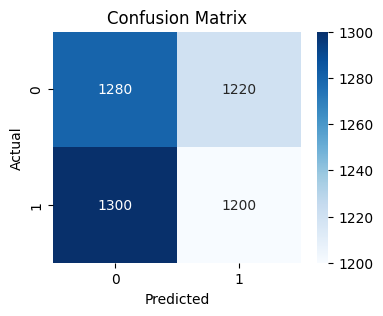

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Example true labels and predicted labels
y_true = [0, 1, 1, 1, 0, 1, 0, 0, 1, 0]      # Actual values
y_pred = [0, 1, 0, 1, 0, 1, 0, 1, 1, 0]      # Predicted values

# Calculate Precision
precision = precision_score(y_true, y_pred)

# Calculate Recall
recall = recall_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
